"""
ATML PA4 — Task 4 from scratch (no reuse):
A clean, single-file PyTorch implementation of a small federated learning framework
with four heterogeneity-mitigation strategies:
- FedProx (local proximal regularization)
- SCAFFOLD (control variates)
- FedGH (server-side gradient harmonization)
- FedSAM (sharpness-aware minimization on clients)


Also includes:
- CIFAR-10 loading and Dirichlet non-IID partitioning
- Simple CNN model
- FedAvg baseline
- Weighted aggregation, client drift metric, logging hooks


HOW TO USE (example):
python ATML-PA4-Task4.py --strategy fedavg --alpha 0.1 --num-clients 10 --rounds 50 --K 5
python ATML-PA4-Task4.py --strategy fedprox --mu 0.01 --alpha 0.1 --num-clients 10 --rounds 50 --K 5
python ATML-PA4-Task4.py --strategy scaffold --alpha 0.1 --num-clients 10 --rounds 50 --K 5
python ATML-PA4-Task4.py --strategy fedgh --alpha 0.1 --num-clients 10 --rounds 50 --K 5
python ATML-PA4-Task4.py --strategy fedsam --rho 0.05 --alpha 0.1 --num-clients 10 --rounds 50 --K 5


Notes:
* Keep the model small to fit within assignment constraints.
* SCAFFOLD doubles comms (sends control variates). FedSAM ~2x local compute.
* FedGH adds O(M^2) server-time pairwise projections per round.


This file is deliberately verbose and self-contained for clarity and grading.
"""

In [13]:
from __future__ import annotations
import argparse
import copy
import math
import os
import random
from dataclasses import dataclass
from typing import Dict, List, Tuple, Iterable, Optional


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

# torchvision is permissible for CIFAR-10
from torchvision import datasets, transforms

# Reproducibility helpers

def set_seed(seed: int = 42):
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)

In [14]:
# ---------------------------
# Simple CNN for CIFAR-10
# ---------------------------
class SmallCNN(nn.Module):
    def __init__(self, num_classes: int = 10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16x16
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 8x8
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# ---------------------------
# Dirichlet non-IID partition
# ---------------------------

def dirichlet_partition_indices(
    targets: torch.Tensor, num_clients: int, alpha: float, seed: int = 42
) -> List[List[int]]:
    """Split dataset indices into num_clients using class-wise Dirichlet(α) proportions.
    Smaller α => higher label skew.
    """
    g = torch.Generator().manual_seed(seed)
    num_classes = int(targets.max().item() + 1)
    class_indices = [torch.where(targets == c)[0].tolist() for c in range(num_classes)]
    for ci in class_indices:
        random.shuffle(ci)

    client_indices = [[] for _ in range(num_clients)]

    for c in range(num_classes):
        # sample proportions for this class
        proportions = torch.distributions.Dirichlet(torch.full((num_clients,), alpha)).sample()
        proportions = (proportions / proportions.sum()).tolist()
        cls_ids = class_indices[c]
        # split cls_ids according to proportions
        prev = 0
        for k in range(num_clients):
            take = int(round(proportions[k] * len(cls_ids)))
            client_indices[k].extend(cls_ids[prev : prev + take])
            prev += take
        # in case of rounding leftovers, dump remainder into last client
        if prev < len(cls_ids):
            client_indices[-1].extend(cls_ids[prev:])

    # shuffle each client list
    for k in range(num_clients):
        random.shuffle(client_indices[k])
    return client_indices


# ---------------------------
# Utilities for (de)flattening params and deltas
# ---------------------------

def get_model_params_vector(model: nn.Module) -> torch.Tensor:
    return torch.cat([p.detach().view(-1) for p in model.parameters()])


def get_model_grads_vector(model: nn.Module) -> torch.Tensor:
    return torch.cat([p.grad.detach().view(-1) if p.grad is not None else torch.zeros_like(p).view(-1) for p in model.parameters()])


def assign_params_from_vector(model: nn.Module, vec: torch.Tensor):
    offset = 0
    with torch.no_grad():
        for p in model.parameters():
            numel = p.numel()
            p.copy_(vec[offset : offset + numel].view_as(p))
            offset += numel


def add_inplace(tensors: Iterable[torch.Tensor], alphas: Iterable[float], out: torch.Tensor):
    """out = sum(alpha_i * tensor_i). Assumes flat vectors of equal shape."""
    out.zero_()
    for t, a in zip(tensors, alphas):
        out.add_(t, alpha=a)

In [15]:
# ---------------------------
# Client logic (baseline + hooks)
# ---------------------------
@dataclass
class ClientConfig:
    lr: float = 0.01
    momentum: float = 0.9
    batch_size: int = 64
    local_epochs: int = 5  # K
    mu: float = 0.0  # for FedProx
    rho: float = 0.0  # for FedSAM


def freeze_bn_running_stats(model: nn.Module):
    for m in model.modules():
        if isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
            m.eval()                      # stop updating running_mean/var
            m.track_running_stats = False # disable counters entirely


class Client:
    def __init__(
        self,
        cid: int,
        dataset: torch.utils.data.Dataset,
        indices: List[int],
        device: torch.device,
        cfg: ClientConfig,
        strategy: str,
        model_template: nn.Module,
        scaffold_ci_template: Optional[List[torch.Tensor]] = None,
    ):
        self.cid = cid
        self.device = device
        self.cfg = cfg
        self.strategy = strategy.lower()
        self.loader = DataLoader(Subset(dataset, indices), batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True)
        self.model = copy.deepcopy(model_template).to(device)

        # SCAFFOLD control variate for this client (list of tensors matching params)
        if self.strategy == "scaffold":
            assert scaffold_ci_template is not None
            self.ci = [torch.zeros_like(t, device=device) for t in scaffold_ci_template]
        else:
            self.ci = None

    def set_model_from_global(self, global_model: nn.Module):
        self.model.load_state_dict(copy.deepcopy(global_model.state_dict()))

    def _scaffold_apply_correction(self, model: nn.Module, c_global: List[torch.Tensor]):
        # add (c - ci) to each parameter's gradient  [SCAFFOLD paper]
        with torch.no_grad():
            for p, ci_p, c_p in zip(model.parameters(), self.ci, c_global):
                if p.grad is None:
                    continue
                p.grad.add_(c_p - ci_p)


    def _fedprox_add_proximal(self, model: nn.Module, global_params: List[torch.Tensor]):
        # add µ/2 * ||theta - theta_g||^2 to loss => grads add µ*(theta - theta_g)
        mu = self.cfg.mu
        if mu <= 0:
            return 0.0
        prox = 0.0
        for p, g in zip(model.parameters(), global_params):
            prox = prox + 0.5 * mu * torch.sum((p - g) ** 2)
        return prox

    def _fedsam_ascent(self, model: nn.Module, rho: float):
        # Perturb weights: w_adv = w + rho * g/||g|| (g is grad w.r.t current w)
        grad_vec = get_model_grads_vector(model)
        eps = 1e-12
        scale = rho / (grad_vec.norm(p=2) + eps)
        offset = 0
        with torch.no_grad():
            for p in model.parameters():
                if p.grad is None:
                    continue
                numel = p.numel()
                p.add_(grad_vec[offset : offset + numel].view_as(p), alpha=scale)
                offset += numel

    def _fedsam_descent_restore(self, model: nn.Module, rho: float):
        # Undo the perturbation by subtracting same delta applied in ascent.
        # NOTE: We recompute using the *current* grad vector, which is at w_adv; to precisely undo, we stored nothing.
        # A more exact impl would store the ascent delta. We'll compute it again from grads-at-w (before ascent),
        # but we no longer have those grads. So we do the simple approach: store ascent deltas.
        pass  # We'll store deltas explicitly below.

    def local_train(
        self,
        global_model: nn.Module,
        c_global: Optional[List[torch.Tensor]] = None,
    ) -> Dict[str, torch.Tensor | List[torch.Tensor]]:
        device = self.device
        self.set_model_from_global(global_model)
        model = self.model
        model.train()
        if self.strategy == "scaffold":
            freeze_bn_running_stats(model)

        # momentum OFF for SCAFFOLD; else use cfg
        use_momentum = 0.0 if self.strategy == "scaffold" else self.cfg.momentum
        wd = 5e-4 if self.strategy == "scaffold" else 0.0
        opt = optim.SGD(model.parameters(), lr=self.cfg.lr, momentum=use_momentum, weight_decay=wd)


        # cache global params for FedProx term
        global_params = [p.detach().clone() for p in global_model.parameters()]
        rho = self.cfg.rho if self.strategy == "fedsam" else 0.0

        total_steps = 0  # count mini-batch steps (needed for SCAFFOLD)

        for ep in range(self.cfg.local_epochs):
            for xb, yb in self.loader:
                xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)

                # ----- forward -----
                opt.zero_grad(set_to_none=True)
                logits = model(xb)
                loss = F.cross_entropy(logits, yb)

                # FedProx proximal term
                if self.strategy == "fedprox" and self.cfg.mu > 0:
                    loss = loss + self._fedprox_add_proximal(model, global_params)

                # guard BEFORE backward
                if not torch.isfinite(loss):
                    print(f"[Client {self.cid}] non-finite loss; breaking batch")
                    break

                # ----- backward -----
                loss.backward()

                # SCAFFOLD correction: g <- g + (ci - c)
                if self.strategy == "scaffold":
                    assert c_global is not None and self.ci is not None
                    self._scaffold_apply_correction(model, c_global)

                # grad guard + light clip
                bad_grad = False
                for p in model.parameters():
                    if p.grad is None: 
                        continue
                    g = p.grad
                    mask = torch.isfinite(g)
                    if not mask.all():
                        g[~mask] = 0.0
                        bad_grad = True
                if bad_grad:
                    # if something blew up, take a tiny step or skip
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)



                # FedSAM two-step or vanilla step
                if self.strategy == "fedsam" and rho > 0:
                    ascent_deltas = []
                    with torch.no_grad():
                        grad_vec = get_model_grads_vector(model)
                        eps = 1e-12
                        scale = rho / (grad_vec.norm(p=2) + eps)
                        off = 0
                        for p in model.parameters():
                            if p.grad is None:
                                ascent_deltas.append(None); continue
                            n = p.numel()
                            delta = grad_vec[off:off+n].view_as(p) * scale
                            p.add_(delta); ascent_deltas.append(delta); off += n

                    opt.zero_grad(set_to_none=True)
                    logits_adv = model(xb)
                    loss_adv = F.cross_entropy(logits_adv, yb)
                    loss_adv.backward()

                    with torch.no_grad():
                        for p, d in zip(model.parameters(), ascent_deltas):
                            if d is not None: p.sub_(d)

                    opt.step()
                else:
                    opt.step()

                total_steps += 1

        # ----- package results -----
        with torch.no_grad():
            theta_i = [p.detach().clone() for p in model.parameters()]
            theta_g = [p.detach().clone() for p in global_model.parameters()]
            deltas  = [ti - tg for ti, tg in zip(theta_i, theta_g)]

        out: Dict[str, torch.Tensor | List[torch.Tensor]] = {
            "params": theta_i,
            "delta": deltas,
            "num_samples": int(len(self.loader.dataset)),
        }

        # SCAFFOLD: ci <- ci - c + (w_t - w_{t+1}^i) / (steps * lr)
        if self.strategy == "scaffold":
            assert self.ci is not None and c_global is not None
            steps = max(total_steps, 1)
            inv = 1.0 / (steps * self.cfg.lr)
            with torch.no_grad():
                for ci_p, c_p, wt_p, wt1i_p in zip(self.ci, c_global, theta_g, theta_i):
                    ci_p.add_(-c_p)
                    ci_p.add_((wt_p - wt1i_p) * inv)
            out["ci"] = [t.detach().clone() for t in self.ci]

        return out





In [16]:
# ---------------------------
# Server & strategies
# ---------------------------
class Server:
    def __init__(self, model: nn.Module, device: torch.device):
        self.model = model.to(device)
        self.device = device

    def aggregate_weighted(self, client_params: List[List[torch.Tensor]], weights: List[float]):
        with torch.no_grad():
            for p_idx, p in enumerate(self.model.parameters()):
                acc = None
                for w, params in zip(weights, client_params):
                    term = params[p_idx].to(self.device) * w
                    acc = term if acc is None else acc + term
                p.copy_(acc)

    def aggregate_from_deltas(self, deltas: List[List[torch.Tensor]], weights: List[float]):
        with torch.no_grad():
            for p_idx, p in enumerate(self.model.parameters()):
                acc = torch.zeros_like(p)
                for w, dlist in zip(weights, deltas):
                    acc.add_(dlist[p_idx].to(self.device), alpha=w)
                p.add_(acc)

    # FedGH: harmonize deltas before averaging
    def harmonize_pairwise(self, flat_updates: List[torch.Tensor]) -> List[torch.Tensor]:
        M = len(flat_updates)
        outs = [u.clone() for u in flat_updates]
        for i in range(M):
            for j in range(i + 1, M):
                gi, gj = outs[i], outs[j]
                dot = torch.dot(gi, gj)
                if dot < 0:
                    # project symmetric
                    gi_norm2 = torch.dot(gi, gi) + 1e-12
                    gj_norm2 = torch.dot(gj, gj) + 1e-12
                    proj_i = dot / gj_norm2
                    proj_j = dot / gi_norm2
                    outs[i] = gi - proj_i * gj
                    outs[j] = gj - proj_j * gi
        return outs


# ---------------------------
# Evaluation & metrics
# ---------------------------
@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device: torch.device) -> Tuple[float, float]:
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = F.cross_entropy(logits, yb, reduction='sum')
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        loss_sum += loss.item()
    return correct / total, loss_sum / total


def compute_drift(global_model: nn.Module, client_param_lists: List[List[torch.Tensor]], device: torch.device) -> float:
    with torch.no_grad():
        gparams = [p.detach().to(device) for p in global_model.parameters()]
        dists = []
        for plist in client_param_lists:
            s = 0.0
            for gp, cp in zip(gparams, plist):
                s += torch.norm(cp.to(device) - gp, p=2).item() ** 2
            dists.append(math.sqrt(s))
        return float(sum(dists) / len(dists))


# ---------------------------
# Data loading
# ---------------------------

def get_cifar10(root: str = "./data"):
    tfm_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
    tfm_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
    train = datasets.CIFAR10(root, train=True, download=True, transform=tfm_train)
    test = datasets.CIFAR10(root, train=False, download=True, transform=tfm_test)
    return train, test




In [17]:
 #---------------------------
# Training orchestration
# ---------------------------

def run(
    strategy: str,
    num_clients: int,
    alpha: float,
    rounds: int,
    K: int,
    batch_size: int,
    lr: float,
    momentum: float,
    mu: float,
    rho: float,
    sample_frac: float,
    seed: int = 42,
    device_str: str = "cuda" if torch.cuda.is_available() else "cpu",
):
    set_seed(seed)
    device = torch.device(device_str)

    # data
    train_set, test_set = get_cifar10()
    test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2)

    # partition
    targets = torch.tensor(train_set.targets)
    splits = dirichlet_partition_indices(targets, num_clients=num_clients, alpha=alpha, seed=seed)

    # model template
    global_model = SmallCNN().to(device)
    server = Server(global_model, device)

    # client configs
    cfg = ClientConfig(lr=lr, momentum=momentum, batch_size=batch_size, local_epochs=K, mu=mu, rho=rho)

    # SCAFFOLD templates
    scaffold_template = None
    if strategy.lower() == "scaffold":
        scaffold_template = [p.detach().clone() for p in global_model.parameters()]

    # build clients
    clients: List[Client] = []
    for cid in range(num_clients):
        clients.append(
            Client(
                cid=cid,
                dataset=train_set,
                indices=splits[cid],
                device=device,
                cfg=cfg,
                strategy=strategy,
                model_template=global_model,
                scaffold_ci_template=scaffold_template,
            )
        )

    # SCAFFOLD global control variate c
    c_global: Optional[List[torch.Tensor]] = None
    if strategy.lower() == "scaffold":
        c_global = [torch.zeros_like(p, device=device) for p in global_model.parameters()]


    # training loop
    frac = sample_frac
    for rnd in range(1, rounds + 1):
        # --- round LR schedule ---
        base_lr = lr
        min_lr  = 0.003  # floor to avoid vanishing updates
        if rnd <= 2:
            lr_r = base_lr * 0.5 * rnd  # warmup: 0.5x, 1.0x
        else:
            import math
            cos = 0.5 * (1.0 + math.cos(math.pi * (rnd - 2) / max(1, (rounds - 2))))
            lr_r = min_lr + (base_lr - min_lr) * cos

        # sample participating clients
        m = max(1, int(round(frac * num_clients)))
        selected = random.sample(range(num_clients), m)

        for idx in selected:
          clients[idx].cfg.lr = lr_r


        # collect results (+ snapshot ci for SCAFFOLD)
        results = []
        old_ci = {}
        for idx in selected:
            if strategy.lower() == "scaffold":
                old_ci[idx] = [t.clone() for t in clients[idx].ci]
            res = clients[idx].local_train(global_model, c_global)
            results.append((idx, res))

        # FILTER bad results
        clean = []
        for cid, res in results:
            if res is None:
                print(f"[Server] skip client {cid}: returned None"); continue
            ns = res.get("num_samples", 0)
            try:
                ns = int(ns)
            except Exception:
                print(f"[Server] skip client {cid}: bad num_samples={res.get('num_samples')}"); continue
            if ns <= 0:
                print(f"[Server] skip client {cid}: num_samples<=0"); continue
            bad = False
            for p in res.get("params", []):
                if not torch.isfinite(p).all():
                    bad = True; break
            if bad:
                print(f"[Server] skip client {cid}: non-finite params"); continue
            clean.append((cid, res))

        if not clean:
            print(f"[Server] Round {rnd:03d}: no valid client results, skipping aggregation")
            acc, loss = evaluate(global_model, test_loader, device)
            print(f"Round {rnd:03d} | clients 00/{num_clients} | drift nan | acc {acc*100:.2f}% | loss {loss:.4f}")
            continue

        # weights
        sizes = [int(res["num_samples"]) for _, res in clean]
        total = sum(sizes)
        weights = [s / total for s in sizes]

        # drift before aggregation
        drift_val = compute_drift(global_model, [res["params"] for _, res in clean], device)

        # aggregate
        if strategy.lower() == "fedgh":
            flat = []
            for _, res in clean:
                deltas = res["delta"]
                flat.append(torch.cat([d.detach().view(-1).to(device) for d in deltas]))
            flat_h = server.harmonize_pairwise(flat)
            shapes = [p.shape for p in global_model.parameters()]
            sizes_layer = [int(torch.tensor(s).prod()) for s in shapes]
            per_client_deltas = []
            for fh in flat_h:
                off = 0; dl = []
                for sz, shp in zip(sizes_layer, shapes):
                    dl.append(fh[off:off+sz].view(shp)); off += sz
                per_client_deltas.append(dl)
            server.aggregate_from_deltas(per_client_deltas, weights)
        else:
            server.aggregate_weighted([res["params"] for _, res in clean], weights)

        # SCAFFOLD: c_global += mean(Δci)  (incremental update)
        # --- SCAFFOLD: c_global += weighted mean(Δci) ---
        if strategy.lower() == "scaffold":
            with torch.no_grad():
                sum_delta = [torch.zeros_like(p, device=device) for p in c_global]
                sum_w = 0.0
                for (cid, res), w in zip(clean, weights):
                    new_ci = res.get("ci", None)
                    prev_ci = old_ci.get(cid, None)
                    if new_ci is None or prev_ci is None:
                        continue
                    for j, (n, o) in enumerate(zip(new_ci, prev_ci)):
                        sum_delta[j].add_((n.to(device) - o.to(device)), alpha=w)
                    sum_w += w
                if sum_w > 0:
                    for j in range(len(c_global)):
                        c_global[j].add_(sum_delta[j])  # weights already normalized to 1
                else:
                    print("[Server] SCAFFOLD: no valid weighted Δci; c_global unchanged")


        # optional diagnostics
        if strategy.lower() == "scaffold":
            with torch.no_grad():
                max_ci = max(float(torch.max(torch.abs(t))) for _, r in clean for t in r.get("ci", []))
                max_cg = max(float(torch.max(torch.abs(t))) for t in c_global)
                # print(f"[Diag] r{rnd:03d} | max|ci|={max_ci:.3f} | max|c|={max_cg:.3f}")

        # eval
        acc, loss = evaluate(global_model, test_loader, device)
        acc, loss = evaluate(global_model, test_loader, device)
        print(f"Round {rnd:03d} | clients {len(clean):02d}/{num_clients} | drift {drift_val:.3f} | acc {acc*100:.2f}% | loss {loss:.4f} | lr {lr_r:.4g}")







In [18]:
# ==== Setup: helpers, logging, and parser (run this once) ====
import io, sys, os, re, time, json, shutil
import pandas as pd
import matplotlib.pyplot as plt

# Assumes a function run(**kwargs) is already defined in another cell.

OUTDIR   = "pa4_task4_runs"   # root for artifacts
ROUNDS   = 50                 # default rounds (consistent across methods)
DOWNLOAD = True               # auto-download zips/plots (Colab)
os.makedirs(OUTDIR, exist_ok=True)

# Parse lines like: Round 001 | clients 10/10 | drift 3.103 | acc 33.10% | loss 2.1145
line_re = re.compile(
    r"Round\s+(\d+)\s+\|\s+clients\s+(\d+)\/(\d+)\s+\|\s+drift\s+([0-9.]+)\s+\|\s+acc\s+([0-9.]+)%\s+\|\s+loss\s+([0-9.]+)"
)

def to_jsonable(x):
    if isinstance(x, dict): return {str(k): to_jsonable(v) for k,v in x.items()}
    if isinstance(x, (list, tuple)): return [to_jsonable(v) for v in x]
    if isinstance(x, (str, int, float, bool)) or x is None: return x
    try:
        import numpy as np
        if isinstance(x, np.generic): return x.item()
    except: pass
    try:
        import torch
        if isinstance(x, (torch.device, torch.dtype)): return str(x)
    except: pass
    return str(x)

class Tee(io.TextIOBase):
    """Write to notebook + file simultaneously (live)."""
    def __init__(self, file_obj, mirror): self.f, self.m = file_obj, mirror
    def write(self, s): self.m.write(s); self.m.flush(); self.f.write(s); self.f.flush(); return len(s)
    def flush(self): self.m.flush(); self.f.flush()

def run_and_log(label: str, cfg: dict):
    """Runs one strategy once, prints live, saves logs/CSV/plots, and optionally zips+downloads."""
    stamp  = time.strftime("%Y%m%d-%H%M%S")
    tag    = f"{label}_alpha{cfg['alpha']}_K{cfg['K']}_N{cfg['num_clients']}_{stamp}"
    run_dir = os.path.join(OUTDIR, tag); os.makedirs(run_dir, exist_ok=True)

    # Save config
    cfg_to_save = dict(cfg); cfg_to_save["label"] = label
    with open(os.path.join(run_dir, "config.json"), "w") as f: json.dump(to_jsonable(cfg_to_save), f, indent=2)

    # Live + file logging
    log_path = os.path.join(run_dir, "train.log")
    with open(log_path, "w") as logf:
        old = sys.stdout; sys.stdout = Tee(logf, old)
        try:
            print("\n" + "="*80); print(f"Running {label}"); print("="*80)
            t0 = time.time()
            run(**cfg)  # prints will appear live AND be written to train.log
            print(f"[{label}] elapsed: {time.time()-t0:.2f}s")
        finally:
            sys.stdout = old

    # Parse metrics from train.log
    rows = []
    with open(log_path) as f:
        for line in f:
            m = line_re.search(line)
            if m:
                rows.append((
                    int(m.group(1)), int(m.group(2)), int(m.group(3)),
                    float(m.group(4)), float(m.group(5))/100.0, float(m.group(6))
                ))
    df = pd.DataFrame(rows, columns=["round","m_clients","n_clients","drift","acc","loss"])
    df.to_csv(os.path.join(run_dir, "metrics.csv"), index=False)

    # Plots
    if not df.empty:
        for y, title, name in [
            ("acc",  f"{label} — Accuracy vs Rounds", "acc_vs_rounds.png"),
            ("loss", f"{label} — Loss vs Rounds",     "loss_vs_rounds.png"),
            ("drift",f"{label} — Drift vs Rounds",    "drift_vs_rounds.png"),
        ]:
            plt.figure(); plt.plot(df["round"], df[y]); plt.xlabel("Round"); plt.ylabel(y.capitalize())
            plt.title(title); plt.tight_layout()
            plt.savefig(os.path.join(run_dir, name), dpi=150); plt.close()

        best = df.loc[df["acc"].idxmax()]
        summary = dict(
            final_round=int(df["round"].iloc[-1]),
            final_acc=float(df["acc"].iloc[-1]),
            best_acc=float(best["acc"]),
            best_round=int(best["round"]),
            final_loss=float(df["loss"].iloc[-1]),
            final_drift=float(df["drift"].iloc[-1]),
        )
        with open(os.path.join(run_dir, "summary.json"), "w") as f: json.dump(summary, f, indent=2)
        print(f"[{label}] Final acc {summary['final_acc']:.3f} | Best {summary['best_acc']:.3f} @ r{summary['best_round']} | Drift {summary['final_drift']:.3f}")
    else:
        print(f"[{label}] WARN: no metrics parsed. Check train.log format.")

    # Zip + optional download
    zip_path = shutil.make_archive(run_dir, "zip", run_dir)
    if DOWNLOAD:
        try:
            from google.colab import files
            files.download(zip_path)
        except Exception as e:
            print(f"[{label}] Download skipped ({e}). Zip at: {zip_path}")

    return run_dir


In [19]:
cfg_fedavg = dict(
    strategy="fedavg", num_clients=10, alpha=0.1, rounds=ROUNDS, K=4,
    batch_size=64, lr=0.01, momentum=0.9, sample_frac=1.0, seed=42, mu=0.0, rho=0.0
)
run_dir_fedavg = run_and_log("FedAvg", cfg_fedavg)



Running FedAvg
Round 001 | clients 10/10 | drift 1.904 | acc 30.17% | loss 2.1054 | lr 0.005
Round 002 | clients 10/10 | drift 2.762 | acc 36.61% | loss 1.8632 | lr 0.01
Round 003 | clients 10/10 | drift 2.562 | acc 43.69% | loss 1.6160 | lr 0.009993
Round 004 | clients 10/10 | drift 2.473 | acc 52.56% | loss 1.4222 | lr 0.00997
Round 005 | clients 10/10 | drift 2.376 | acc 54.19% | loss 1.3038 | lr 0.009933
Round 006 | clients 10/10 | drift 2.350 | acc 58.18% | loss 1.1787 | lr 0.009881
Round 007 | clients 10/10 | drift 2.328 | acc 59.62% | loss 1.1331 | lr 0.009814
Round 008 | clients 10/10 | drift 2.315 | acc 62.57% | loss 1.0672 | lr 0.009734
Round 009 | clients 10/10 | drift 2.298 | acc 62.62% | loss 1.0558 | lr 0.009639
Round 010 | clients 10/10 | drift 2.282 | acc 64.81% | loss 1.0131 | lr 0.009531
Round 011 | clients 10/10 | drift 2.287 | acc 67.36% | loss 0.9503 | lr 0.00941
Round 012 | clients 10/10 | drift 2.272 | acc 67.96% | loss 0.9233 | lr 0.009277
Round 013 | clients 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
cfg_fedprox = dict(
    strategy="fedprox", num_clients=10, alpha=0.1, rounds=ROUNDS, K=5,
    batch_size=64, lr=0.01, momentum=0.9, sample_frac=1.0, seed=42, mu=0.01, rho=0.0
)
run_dir_fedprox = run_and_log("FedProx", cfg_fedprox)



Running FedProx
Round 001 | clients 10/10 | drift 1.930 | acc 32.25% | loss 2.0977 | lr 0.005
Round 002 | clients 10/10 | drift 2.568 | acc 38.16% | loss 1.8163 | lr 0.01
Round 003 | clients 10/10 | drift 2.428 | acc 47.13% | loss 1.5563 | lr 0.009993
Round 004 | clients 10/10 | drift 2.295 | acc 51.98% | loss 1.3992 | lr 0.00997
Round 005 | clients 10/10 | drift 2.254 | acc 56.43% | loss 1.2869 | lr 0.009933
Round 006 | clients 10/10 | drift 2.208 | acc 58.56% | loss 1.2019 | lr 0.009881
Round 007 | clients 10/10 | drift 2.190 | acc 60.74% | loss 1.1292 | lr 0.009814
Round 008 | clients 10/10 | drift 2.192 | acc 62.21% | loss 1.0804 | lr 0.009734
Round 009 | clients 10/10 | drift 2.180 | acc 63.20% | loss 1.0439 | lr 0.009639
Round 010 | clients 10/10 | drift 2.168 | acc 65.14% | loss 0.9856 | lr 0.009531
Round 011 | clients 10/10 | drift 2.178 | acc 66.25% | loss 0.9523 | lr 0.00941
Round 012 | clients 10/10 | drift 2.150 | acc 67.63% | loss 0.9215 | lr 0.009277
Round 013 | clients 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
cfg_scaffold = dict(
    strategy="scaffold",
    num_clients=10, alpha=0.1, rounds=ROUNDS, K=6,
    batch_size=64, lr=0.09, momentum=0.0, sample_frac=1.0,
    seed=42, mu=0.0, rho=0.0
)
run_dir_scaffold = run_and_log("SCAFFOLD", cfg_scaffold)



Running SCAFFOLD
Round 001 | clients 10/10 | drift 2.142 | acc 30.29% | loss 2.0682 | lr 0.045
Round 002 | clients 10/10 | drift 3.812 | acc 39.68% | loss 1.7421 | lr 0.09
Round 003 | clients 10/10 | drift 3.286 | acc 48.24% | loss 1.5006 | lr 0.08991
Round 004 | clients 10/10 | drift 3.071 | acc 54.12% | loss 1.3327 | lr 0.08963
Round 005 | clients 10/10 | drift 3.037 | acc 59.72% | loss 1.1408 | lr 0.08916
Round 006 | clients 10/10 | drift 3.040 | acc 62.87% | loss 1.0579 | lr 0.08852
Round 007 | clients 10/10 | drift 3.030 | acc 64.70% | loss 1.0287 | lr 0.08769
Round 008 | clients 10/10 | drift 3.013 | acc 66.59% | loss 0.9642 | lr 0.08669
Round 009 | clients 10/10 | drift 2.995 | acc 67.61% | loss 0.9463 | lr 0.08551
Round 010 | clients 10/10 | drift 2.954 | acc 68.85% | loss 0.9105 | lr 0.08417
Round 011 | clients 10/10 | drift 2.906 | acc 69.12% | loss 0.8836 | lr 0.08267
Round 012 | clients 10/10 | drift 2.863 | acc 70.02% | loss 0.8619 | lr 0.08101
Round 013 | clients 10/10 |

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# ---- FedGH ----
cfg_fedgh = dict(
    strategy="fedgh",
    num_clients=10, alpha=0.1,
    rounds=30, K=5,
    batch_size=64,
    lr=0.02, momentum=0.9,
    sample_frac=1.0,
    seed=42,
    mu=0.0,
    rho=0.0,
)
run_dir_fedgh = run_and_log("FedGH", cfg_fedgh)



Running FedGH
Round 001 | clients 10/10 | drift 3.100 | acc 34.80% | loss 2.1138 | lr 0.01
Round 002 | clients 10/10 | drift 4.644 | acc 41.32% | loss 1.8136 | lr 0.02
Round 003 | clients 10/10 | drift 4.605 | acc 51.54% | loss 1.4760 | lr 0.01995
Round 004 | clients 10/10 | drift 4.502 | acc 57.17% | loss 1.2849 | lr 0.01979
Round 005 | clients 10/10 | drift 4.452 | acc 60.38% | loss 1.1629 | lr 0.01952
Round 006 | clients 10/10 | drift 4.439 | acc 62.48% | loss 1.0783 | lr 0.01916
Round 007 | clients 10/10 | drift 4.376 | acc 64.24% | loss 1.0315 | lr 0.0187
Round 008 | clients 10/10 | drift 4.351 | acc 67.23% | loss 0.9672 | lr 0.01815
Round 009 | clients 10/10 | drift 4.275 | acc 67.45% | loss 0.9619 | lr 0.01751
Round 010 | clients 10/10 | drift 4.194 | acc 69.69% | loss 0.8983 | lr 0.0168
Round 011 | clients 10/10 | drift 4.130 | acc 70.17% | loss 0.8837 | lr 0.01602
Round 012 | clients 10/10 | drift 3.960 | acc 70.54% | loss 0.8693 | lr 0.01519
Round 013 | clients 10/10 | drift

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
# ---- FedSAM ----
cfg_fedsam = dict(
    strategy="fedsam",
    num_clients=10, alpha=0.1,
    rounds=30, K=5,
    batch_size=64,
    lr=0.02, momentum=0.9,
    sample_frac=1.0,
    seed=42,
    mu=0.0,
    rho=0.05,  # try 0.03–0.08; lower if noisy, higher if underfitting
)
run_dir_fedsam = run_and_log("FedSAM", cfg_fedsam)



Running FedSAM
Round 001 | clients 10/10 | drift 3.248 | acc 31.75% | loss 2.1699 | lr 0.01
Round 002 | clients 10/10 | drift 4.656 | acc 34.26% | loss 1.9484 | lr 0.02
Round 003 | clients 10/10 | drift 4.527 | acc 46.54% | loss 1.6149 | lr 0.01995
Round 004 | clients 10/10 | drift 4.371 | acc 52.69% | loss 1.4189 | lr 0.01979
Round 005 | clients 10/10 | drift 4.272 | acc 57.39% | loss 1.2895 | lr 0.01952
Round 006 | clients 10/10 | drift 4.192 | acc 60.59% | loss 1.1873 | lr 0.01916
Round 007 | clients 10/10 | drift 4.103 | acc 62.96% | loss 1.1088 | lr 0.0187
Round 008 | clients 10/10 | drift 4.014 | acc 63.98% | loss 1.0769 | lr 0.01815
Round 009 | clients 10/10 | drift 3.889 | acc 65.72% | loss 1.0228 | lr 0.01751
Round 010 | clients 10/10 | drift 3.792 | acc 67.30% | loss 0.9707 | lr 0.0168
Round 011 | clients 10/10 | drift 3.709 | acc 67.80% | loss 0.9572 | lr 0.01602
Round 012 | clients 10/10 | drift 3.527 | acc 68.84% | loss 0.9291 | lr 0.01519
Round 013 | clients 10/10 | drif

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,label,dir,best_acc,best_round,final_acc,final_loss
0,SCAFFOLD,pa4_task4_runs/SCAFFOLD_alpha0.1_K6_N10_202511...,0.7574,45,0.7559,0.7208
1,FedAvg,pa4_task4_runs/FedAvg_alpha0.1_K4_N10_20251113...,0.7521,45,0.7513,0.7831
2,FedProx,pa4_task4_runs/FedProx_alpha0.1_K5_N10_2025111...,0.7473,50,0.7473,0.8138
3,FedAvg,pa4_task4_runs/FedAvg_alpha0.1_K5_N10_20251113...,0.7447,30,0.7447,0.7668
4,FedGH,pa4_task4_runs/FedGH_alpha0.1_K5_N10_20251113-...,0.7430,28,0.7426,0.8389
5,FedGH,pa4_task4_runs/FedGH_alpha0.1_K5_N10_20251113-...,0.7428,26,0.7403,0.7807
6,FedProx,pa4_task4_runs/FedProx_alpha0.1_K5_N10_2025111...,0.7418,29,0.7407,0.7751
7,FedSAM,pa4_task4_runs/FedSAM_alpha0.1_K5_N10_20251113...,0.7417,30,0.7417,0.7521
8,FedSAM,pa4_task4_runs/FedSAM_alpha0.1_K5_N10_20251113...,0.7343,30,0.7343,0.7760
9,SCAFFOLD,pa4_task4_runs/SCAFFOLD_alpha0.1_K6_N10_202511...,0.7224,30,0.7224,0.8022


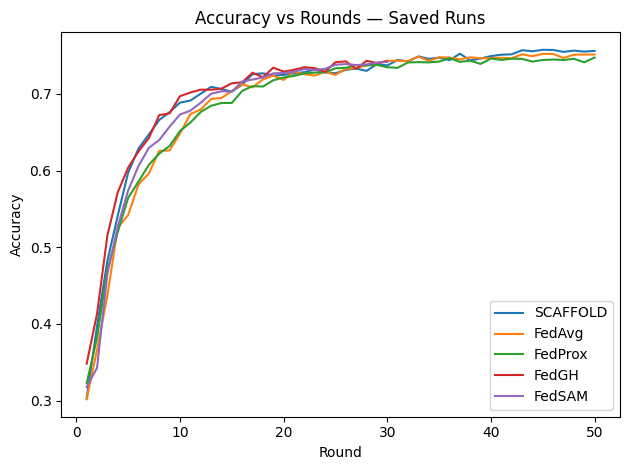

In [24]:
# ---- Build leaderboard from pa4_task4_runs ----
import os, json, pandas as pd, glob, matplotlib.pyplot as plt

ROOT = "pa4_task4_runs"
rows = []
for d in sorted(glob.glob(os.path.join(ROOT, "*"))):
    summ = os.path.join(d, "summary.json")
    if not os.path.exists(summ): 
        continue
    try:
        with open(summ) as f:
            s = json.load(f)
        label = os.path.basename(d).split("_")[0]  # FedAvg / FedProx / ...
        rows.append({
            "label": label,
            "dir": d,
            "best_acc": s.get("best_acc", float("nan")),
            "best_round": s.get("best_round", None),
            "final_acc": s.get("final_acc", float("nan")),
            "final_loss": s.get("final_loss", float("nan")),
        })
    except Exception:
        pass

lb = pd.DataFrame(rows).sort_values("best_acc", ascending=False).reset_index(drop=True)
display(lb)

# Combined accuracy from the latest metrics.csv of each label
plt.figure()
for label in lb["label"].unique():
    # pick the newest dir for that label
    dirs = [r["dir"] for _, r in lb.iterrows() if r["label"] == label]
    if not dirs: 
        continue
    latest = max(dirs, key=os.path.getmtime)
    mpath = os.path.join(latest, "metrics.csv")
    if os.path.exists(mpath):
        df = pd.read_csv(mpath)
        plt.plot(df["round"], df["acc"], label=label)
plt.xlabel("Round"); plt.ylabel("Accuracy"); plt.title("Accuracy vs Rounds — Saved Runs")
plt.legend(); plt.tight_layout(); plt.show()
